## Procesamiento y extracción de características de una señal ECG utilizando libreria biosignals

#### Importación de librerias

In [64]:
import biosignalsnotebooks as bsnb
import numpy as np
import matplotlib.pyplot as plt
import scipy
import neurokit2 as nk

from math import log10


#### Importación de la señal

In [54]:
SenalECG = np.genfromtxt("Signals/ECG_Reposo_Sujeto1.txt", delimiter = "\t", skip_header = 3)
Fs = 1000
ECG = SenalECG[:,5]
time = bsnb.generate_time(ECG, Fs)


#### Preprocesamiento y visualización

In [55]:
from numpy import array, mean, average, std, sum, sqrt, where, argmax
from numpy.random import normal

bits = 10 # Bits de la salida 
volt_range = 3

ecg_signal = (ECG * volt_range/(2**bits - 1))
# ecg_signal = ECG * ((Fs/2**10) - (1/2) * 3.3) / # 1100 Funcion de transferenica
ecg_signal = ecg_signal -np.mean(ecg_signal)

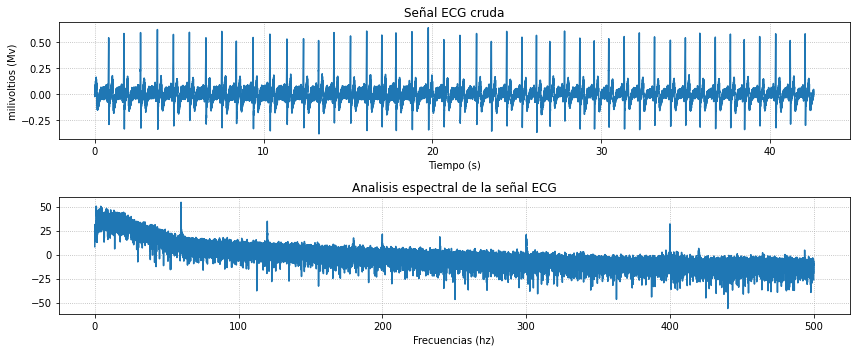

In [59]:
#Transformada de Fourier
freq_axis_1, power_spect_1 = bsnb.plotfft(ecg_signal, Fs)
count = 0
for i in power_spect_1:
    power_spect_1[count]=20 * log10(i)
    count+=1
#Visualización de la señal
plt.figure(figsize=(12,5))
plt.subplot(211)
plt.subplots_adjust(hspace=0.6, wspace=0.6)
plt.plot(time,ecg_signal)
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("milivoltios (Mv)")
plt.title("Señal ECG cruda")    # graficamos la señal

#Respuesta en frecuecnia
plt.subplot(212)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal ECG")
plt.xlabel("Frecuencias (hz)")
plt.plot(freq_axis_1, power_spect_1)
plt.tight_layout()
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EMGyFFT_crudo.png', transparent=False, )
plt.show()

In [ ]:
from math import log10
from numpy import ptp, zeros, mean

# Finding the maximum and minimum values of the ECG signal
max_ecg = max(ecg_signal)
min_ecg = min(ecg_signal)

# Calculating the amplitude of the signal
vpp_signal_ecg = max_ecg - min_ecg

# Notice that this procedure is condensed in a single function in the numpy Python package:
vpp_signal_ecg = ptp(ecg_signal)

# finding R peaks
time_r_peaks, amplitude_r_peaks = bsnb.detect_r_peaks(ecg_signal, Fs, time_units=True, plot_result= False)

#Compute average noise amplitude
vpp_noise_ecg = []

# For this task, we will follow the same procedure as shown before, but store the values in a list, so that we can then calculate the mean value.
for t in time_r_peaks:
    start = int((t + 0.5) * Fs) # 0.5 - time between a peak and a flat 
    end = int((t + 0.65)* Fs) # 0.65 time between a peak and the end of the flat
    interval = ecg_signal[start:end]
    vpp = ptp(interval)
    vpp_noise_ecg.append(vpp)
    
vpp_noise_ecg = mean(vpp_noise_ecg)

snr_ecg = vpp_signal_ecg/vpp_noise_ecg

# The multiplication by 20 is because the signals are in the unit of (micro)Siemes
snr_ecg_db = 20 * log10(snr_ecg)

print("SNR for ECG signal: {}".format(snr_ecg))
print("SNR for ECG signal: {} dB".format(snr_ecg_db))

SNR for ECG signal: 8.853982300884963
SNR for ECG signal: 18.942772989776216 dB


#### Filtrado

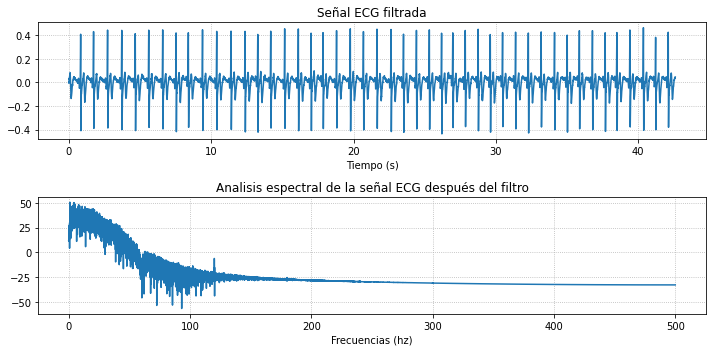

In [62]:
from scipy.signal import iirnotch, lfilter


# Digital bandpass filtering with a cutoff frequency f of 0.5-40 Hz
ecgfilter_signal = bsnb.bandpass(ecg_signal, f1=0.5,f2=40, order=4, fs=Fs)

# Utilizar filtros Notch para quitar frecuencias que hagan ruido # Frecuencia de muestreo (Hz)
f0 = 60.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, Fs)
ecgfilter_signal = lfilter(b, a, ecgfilter_signal)
ecgfilter_signal = lfilter(b, a, ecgfilter_signal)

#FFT después del filtrado
freq_axis_2, power_spect_2 = bsnb.plotfft(ecgfilter_signal, Fs)
count2 = 0
for j in power_spect_2:
    power_spect_2[count2]=20 * log10(j)
    count2+=1
#Visualización señal filtrada
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.subplots_adjust(hspace=0.6, wspace=0.6)
plt.plot(time,ecgfilter_signal) # graficamos la señal filtrada
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.title("Señal ECG filtrada")

#Visualizacion de la respuesta en frecuencia después del filtro
plt.subplot(212)
plt.grid(linestyle=":")
plt.title("Analisis espectral de la señal ECG después del filtro")
plt.xlabel("Frecuencias (hz)")
plt.plot(freq_axis_2, power_spect_2)
#plt.xlim(0,100)
plt.tight_layout()
fig = plt.gcf()
fig.set_facecolor('white')
#plt.savefig('EMGyFFT_filtrada.png', transparent=False, )

In [ ]:
from numpy import ptp, zeros, mean

# Finding the maximum and minimum values of the ECG signal
max_ecgfilter = max(ecgfilter_signal)
min_ecgfilter = min(ecgfilter_signal)

# Calculating the amplitude of the signal
vpp_signal_ecgfilter = max_ecgfilter - min_ecgfilter

# Notice that this procedure is condensed in a single function in the numpy Python package:
vpp_signal_ecgfilter = ptp(ecgfilter_signal)

# finding R peaks
time_r_peaksfilter, amplitude_r_peaksfilter = bsnb.detect_r_peaks(ecgfilter_signal, Fs, time_units=True, plot_result= True)

#Compute average noise amplitude
vpp_noise_ecgfilter = []

# For this task, we will follow the same procedure as shown before, but store the values in a list, so that we can then calculate the mean value.
for t in time_r_peaksfilter:
    start = int((t + 0.5) * Fs) # 0.5 - time between a peak and a flat 
    end = int((t + 0.65)* Fs) # 0.65 time between a peak and the end of the flat
    interval = ecgfilter_signal[start:end]
    vppfilter = ptp(interval)
    vpp_noise_ecgfilter.append(vppfilter)
    
vpp_noise_ecgfilter = mean(vpp_noise_ecgfilter)

snr_ecgfilter = vpp_signal_ecgfilter/vpp_noise_ecgfilter

# The multiplication by 20 is because the signals are in the unit of (micro)Siemes
snr_ecg_dbfilter = 20 * log10(snr_ecgfilter)

print("SNR for ECG signal filtered: {}".format(snr_ecgfilter))
print("SNR for ECG signal filtered: {} dB".format(snr_ecg_dbfilter))

SNR for ECG signal: 28.48570984174518
SNR for ECG signal: 29.09254092416844 dB


In [63]:
bsnb.plot([time], [ecgfilter_signal], legend_label=["Filtered signal"], y_axis_label=[" amplitude (Mv)"], x_axis_label="Time (s)")

c:\Users\FRANCISCO\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


<Figure size 864x432 with 0 Axes>

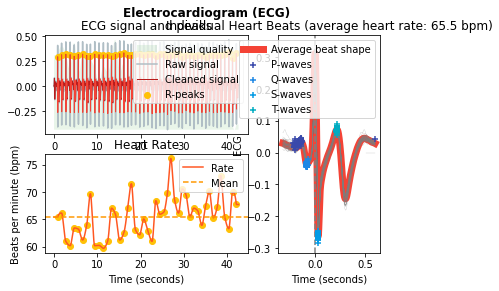

In [66]:
signals, info = nk.ecg_process(ecgfilter_signal, sampling_rate=Fs)

nk.ecg_plot(signals, info)


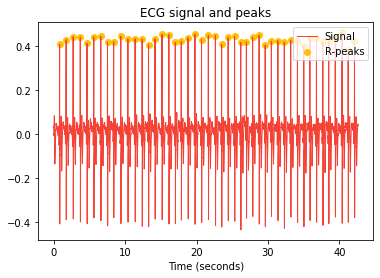

In [67]:
signals, info = nk.ecg_peaks(ecgfilter_signal, sampling_rate=Fs, correct_artifacts=True, show=True)


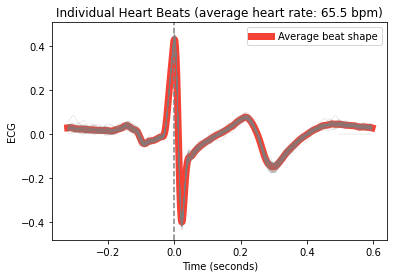

In [68]:
qrs_epochs = nk.ecg_segment(ecgfilter_signal, rpeaks=None, sampling_rate=Fs, show=True)


In [70]:
dictParameters = bsnb.hrv_parameters(ecg_signal, Fs, signal=True)
print(dictParameters)

{'MaxRR': 1.005023592103102, 'MinRR': 0.7880184980868101, 'AvgRR': 0.9171326400463234, 'MaxBPM': 76.14034460570525, 'MinBPM': 59.70009109382657, 'AvgBPM': 65.42128954975308, 'SDNN': 0.05148593004404226, 'SD1': 0.040181639816521106, 'SD2': 0.06072098324842404, 'SD1/SD2': 0.6617422457098302, 'NN20': 35, 'pNN20': 79, 'NN50': 19, 'pNN50': 43, 'ULF_Power': 0.0, 'VLF_Power': 0.0, 'LF_Power': 0.00064, 'HF_Power': 0.00115, 'LF_HF_Ratio': 0.5565217391304348, 'Total_Power': 0.00179}
